To begin copy this notebook to your own drive:

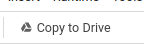


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [1]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
From (redirected): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn&confirm=t&uuid=82863642-b9eb-446d-86ce-b90ecce1a5fa
To: /content/glove.npy
100%|██████████| 480M/480M [00:06<00:00, 79.7MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 47.8MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
!pip install datasets
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:

from nltk.tokenize import word_tokenize
import json
import nltk

nltk.download('punkt_tab')
with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [11]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [5]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [6]:
!pip install evaluate
!pip install --upgrade sympy
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [7]:
#from datasets import load_metric



metric = evaluate.load("accuracy")
#metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [8]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:

  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:

      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]

    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [9]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, p=0, hidden_layers = 1, hidden_layer_size =256, activation = nn.ReLU()):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          self.hidden_layers = hidden_layers
          self.hidden_layer_size = hidden_layer_size
          self.activation = activation
          self.dropout = nn.Dropout(p)

          # YOUR CODE HERE
          self.p = p
          self.loss = nn.CrossEntropyLoss()

          layers = []
          if self.hidden_layers == 0:
              layers = [nn.Linear(self.embeddings.embedding_dim, self.num_labels)]
          else:
              for i in range(self.hidden_layers):
                  if i == 0:
                      layers.append(nn.Linear(self.embeddings.embedding_dim, self.hidden_layer_size))
                  else:
                      layers.append(nn.Linear(self.hidden_layer_size, self.hidden_layer_size))
                  layers.append(self.activation)
              layers.append(nn.Linear(self.hidden_layer_size, self.num_labels),)

          self.classifier = nn.Sequential(*layers)

          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embeddings = self.embeddings(input_ids) # Retrieve token embeddings
      if self.training:
           # Apply dropout to embeddings during training to prevent overfitting
           # Create a dropout mask where each token is with probability (1 - self.dropout_prob)
          dropout_mask = torch.bernoulli((1 - self.p) * torch.ones_like(attention_masks, dtype=torch.float32))
          # Update mask_tokens and token_embeddings based on the dropout mask
          attention_masks[dropout_mask == 0] = 0
          embeddings[dropout_mask == 0, :] = 0
      avg = torch.sum(embeddings, dim=1) / torch.sum(attention_masks, dim=1).unsqueeze(-1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



# (a) Implementation of DAN model

In [12]:
import wandb
from transformers import Trainer, TrainingArguments
from transformers.integrations import TensorBoardCallback

# Initialize wandb
# Increase the initialization timeout
# Define the training arguments
num_epochs = 30
training_args = TrainingArguments(
    "DAN",
    num_train_epochs=num_epochs,  # Ensure at least 10
    per_device_train_batch_size=128,
    per_device_eval_batch_size=8,
    learning_rate=0.01,
    logging_strategy="epoch",
    save_total_limit=2,
    log_level="error",
    evaluation_strategy="epoch",
    report_to = "none"
)
model = DAN()
collator =  DataCollatorWithPadding()
# Define the trainer
trainerA = Trainer(
    model=model,
    data_collator=collator,
    args=training_args,
    callbacks=[
        TensorBoardCallback,  # TensorBoard integration
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainerA.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.476500,0.428096,0.799840
2,0.410100,0.391859,0.825520
3,0.389200,0.426737,0.804440
4,0.382000,0.382454,0.829960
5,0.384100,0.378997,0.832600
6,0.375400,0.388675,0.825600
7,0.375000,0.390636,0.827160
8,0.367500,0.388201,0.827480
9,0.370800,0.377082,0.834840
10,0.366000,0.387986,0.824320


TrainOutput(global_step=5880, training_loss=0.3610055819660628, metrics={'train_runtime': 989.6041, 'train_samples_per_second': 757.879, 'train_steps_per_second': 5.942, 'total_flos': 0.0, 'train_loss': 0.3610055819660628, 'epoch': 30.0})

## Plot results - Section A

In [ ]:
!pip install matplotlib

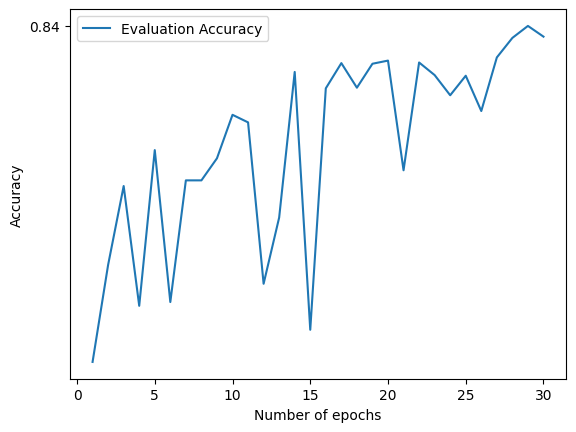

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract accuracy from the log history
eval_accuracy = [d['eval_accuracy'] for d in trainerA.state.log_history if 'eval_accuracy' in d]

# Find the maximum evaluation accuracy
max_accuracy = np.max(np.array(eval_accuracy))
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')

# Add the max accuracy value to the y-ticks, so it shows up on the y-axis
plt.yticks(list(plt.yticks()[0]) + [max_accuracy])

# Plot the accuracy values over epochs
plt.plot(np.arange(1, len(eval_accuracy) + 1), eval_accuracy, label='Evaluation Accuracy')
plt.legend()

# Display the plot
plt.show()


# (b) Word dropout


In [ ]:
co = DataCollatorWithPadding()

num_epochs = 20
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=num_epochs , #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.01,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
training_results = [] # Containers to store results and trainers
trainers = []

alpha_values = np.linspace(0.1, 0.5, 5) # Hyperparameter values



for alpha in alpha_values:
    model_instance = DAN(p=alpha)     # Create a new model with the given alpha

    # Create a new Trainer with the model and training configurations
    trainers.append(Trainer(
        model=model_instance,
        data_collator=co,
        args=training_args,
        callbacks=[TensorBoardCallback()],  # Adding TensorBoard callback
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    ))

    trainers[-1].train()     # Train the model

    # Store evaluation accuracy for each epoch in the list
    training_results.append([log['eval_accuracy'] for log in trainers[-1].state.log_history if 'eval_accuracy' in log])




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'loss': 0.4881, 'grad_norm': 0.3463887572288513, 'learning_rate': 0.0095, 'epoch': 1.0}
{'eval_loss': 0.4082746207714081, 'eval_accuracy': 0.81656, 'eval_runtime': 25.8568, 'eval_samples_per_second': 966.864, 'eval_steps_per_second': 120.858, 'epoch': 1.0}
{'loss': 0.4168, 'grad_norm': 0.3953781723976135, 'learning_rate': 0.009000000000000001, 'epoch': 2.0}
{'eval_loss': 0.3915628492832184, 'eval_accuracy': 0.82488, 'eval_runtime': 25.1236, 'eval_samples_per_second': 995.08, 'eval_steps_per_second': 124.385, 'epoch': 2.0}
{'loss': 0.3954, 'grad_norm': 0.23576900362968445, 'learning_rate': 0.0085, 'epoch': 3.0}
{'eval_loss': 0.38484492897987366, 'eval_accuracy': 0.82836, 'eval_runtime': 25.4102, 'eval_samples_per_second': 983.856, 'eval_steps_per_second': 122.982, 'epoch': 3.0}
{'loss': 0.394, 'grad_norm': 0.31137022376060486, 'learning_rate': 0.008, 'epoch': 4.0}
{'eval_loss': 0.3917539715766907, 'eval_accuracy': 0.82548, 'eval_runtime': 26.33, 'eval_samples_per_second': 949.487, 'eva

## Plot Results - Section B

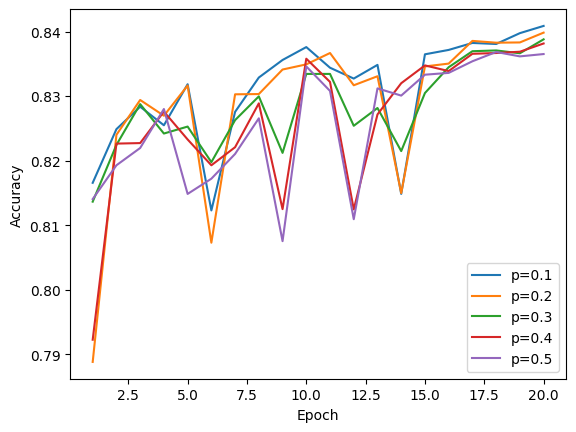

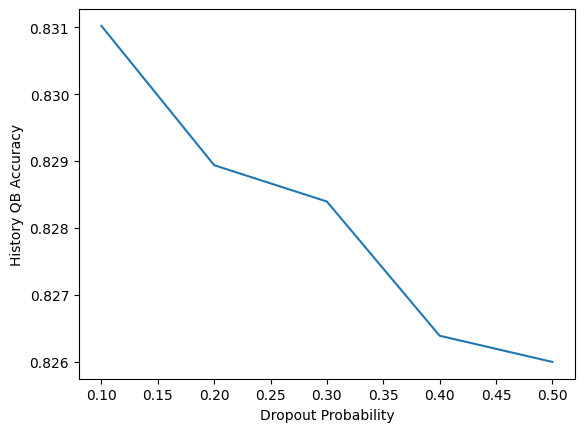

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
range_ = np.linspace(0.1, 0.5, 5)
for i, result in enumerate(training_results):

  plt.plot(np.arange(1, num_epochs + 1), result, label=f"p={range_[i]:.1f}")
plt.legend()
plt.show()

plt.xlabel('Dropout Probability')
plt.ylabel('History QB Accuracy')
plt.plot(alpha_values, np.mean(training_results, axis=1))
plt.show()



# (C) 4 models with an increasing number of hidden layers




In [ ]:
import wandb
from transformers import Trainer, TrainingArguments
from transformers.integrations import TensorBoardCallback
from transformers import DataCollatorWithPadding

# Define number of epochs and training arguments
num_epochs = 30
training_args = TrainingArguments(
    "DAN",
    num_train_epochs=num_epochs,  # must be at least 10
    per_device_train_batch_size=128,
    per_device_eval_batch_size=8,
    learning_rate=0.01,
    logging_strategy="epoch",
    save_total_limit=2,
    log_level="error",
    evaluation_strategy="epoch",
)

# Containers to store trainers and evaluation results
training_results = []  # Stores evaluation accuracies across epochs for each configuration
trainers = []
#collator = DataCollatorWithPadding()

# Train and evaluate models with varying number of hidden layers
for num_layers in range(4):  # Loop over 0 to 3 hidden layers
    model = DAN(hidden_layers=num_layers)
    trainer = Trainer(
        model=model,
        data_collator=collator,
        args=training_args,
        callbacks=[TensorBoardCallback],
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )
    # Train the model
    trainer.train()

    # Extract evaluation accuracies from trainer's log history
    eval_accuracies = [d['eval_accuracy'] for d in trainer.state.log_history if 'eval_accuracy' in d]
    training_results.append(eval_accuracies)  # Append the results for this model
    trainers.append(trainer)  # Store the trainer object

# `training_results` is now a 2D list of shape (4, num_epochs)
# Each row corresponds to one configuration, and columns are eval accuracies for each epoch


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.5522, 'grad_norm': 0.06134812533855438, 'learning_rate': 0.009666666666666667, 'epoch': 1.0}
{'eval_loss': 0.48805534839630127, 'eval_accuracy': 0.79056, 'eval_runtime': 13.8222, 'eval_samples_per_second': 1808.686, 'eval_steps_per_second': 226.086, 'epoch': 1.0}
{'loss': 0.4622, 'grad_norm': 0.06902468949556351, 'learning_rate': 0.009333333333333334, 'epoch': 2.0}
{'eval_loss': 0.4471816420555115, 'eval_accuracy': 0.8038, 'eval_runtime': 14.0037, 'eval_samples_per_second': 1785.245, 'eval_steps_per_second': 223.156, 'epoch': 2.0}
{'loss': 0.4343, 'grad_norm': 0.043713510036468506, 'learning_rate': 0.009000000000000001, 'epoch': 3.0}
{'eval_loss': 0.426630437374115, 'eval_accuracy': 0.81388, 'eval_runtime': 13.9384, 'eval_samples_per_second': 1793.605, 'eval_steps_per_second': 224.201, 'epoch': 3.0}
{'loss': 0.4161, 'grad_norm': 0.06469417363405228, 'learning_rate': 0.008666666666666668, 'epoch': 4.0}
{'eval_loss': 0.4160611033439636, 'eval_accuracy': 0.81712, 'eval_runtime'

# Plot section C

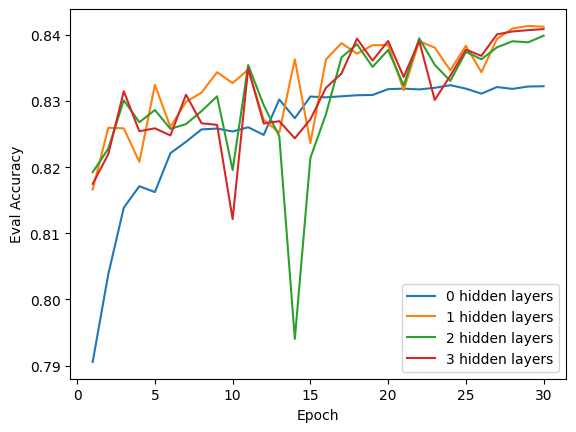

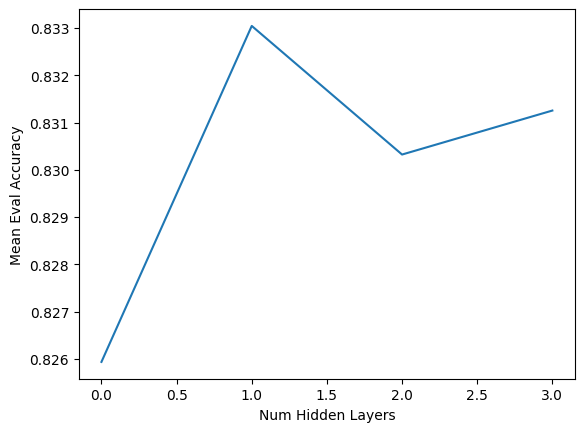

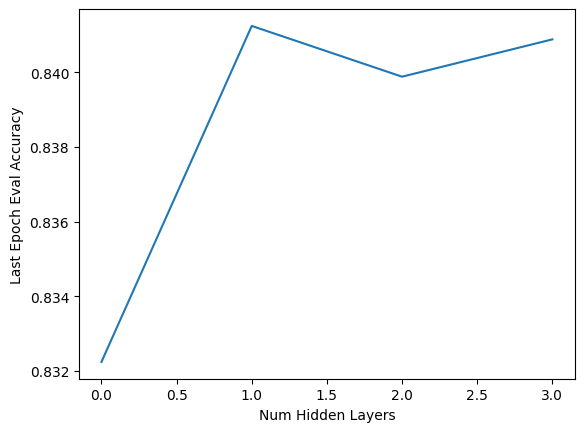

In [ ]:
# Plots
from matplotlib import pyplot as plt
plt.xlabel('Epoch')
plt.ylabel('Eval Accuracy')
for i, result in enumerate(training_results):
  plt.plot(np.arange(1, num_epochs + 1), result, label=f"{i} hidden layers")
plt.legend()
plt.show()

plt.xlabel('Num Hidden Layers')
plt.ylabel('Mean Eval Accuracy')
plt.plot(np.arange(4), np.mean(training_results, axis=1))
plt.show()

plt.xlabel('Num Hidden Layers')
plt.ylabel('Last Epoch Eval Accuracy')
plt.plot(np.arange(4), np.array(training_results)[:, -1])
plt.show()


# Section D

In [ ]:

import wandb
from transformers import Trainer, TrainingArguments
from transformers.integrations import TensorBoardCallback
#from transformers import DataCollatorWithPadding


num_epochs = 30
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=num_epochs , #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.01,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
results = []
trainers = []
collator = DataCollatorWithPadding()
activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
for activation_func in activation_functions:
  model = DAN(activation=activation_func)
  trainers.append(Trainer(
      model=model,
      data_collator=collator,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE
                    TensorBoardCallback
                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  ))
  trainers[-1].train()
  results.append([d['eval_accuracy'] for d in trainers[-1].state.log_history if 'eval_accuracy' in d ])



wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'loss': 0.4749, 'grad_norm': 0.12925215065479279, 'learning_rate': 0.009666666666666667, 'epoch': 1.0}
{'eval_loss': 0.4422258734703064, 'eval_accuracy': 0.7918, 'eval_runtime': 25.6686, 'eval_samples_per_second': 973.951, 'eval_steps_per_second': 121.744, 'epoch': 1.0}
{'loss': 0.4069, 'grad_norm': 0.4964388310909271, 'learning_rate': 0.009333333333333334, 'epoch': 2.0}
{'eval_loss': 0.3897794783115387, 'eval_accuracy': 0.8258, 'eval_runtime': 25.2139, 'eval_samples_per_second': 991.518, 'eval_steps_per_second': 123.94, 'epoch': 2.0}
{'loss': 0.3878, 'grad_norm': 0.2623994052410126, 'learning_rate': 0.009000000000000001, 'epoch': 3.0}
{'eval_loss': 0.42739570140838623, 'eval_accuracy': 0.80448, 'eval_runtime': 25.743, 'eval_samples_per_second': 971.137, 'eval_steps_per_second': 121.392, 'epoch': 3.0}
{'loss': 0.3806, 'grad_norm': 0.1330881118774414, 'learning_rate': 0.008666666666666668, 'epoch': 4.0}
{'eval_loss': 0.3850345015525818, 'eval_accuracy': 0.82916, 'eval_runtime': 26.9847

In [ ]:
!pip install matplotlib

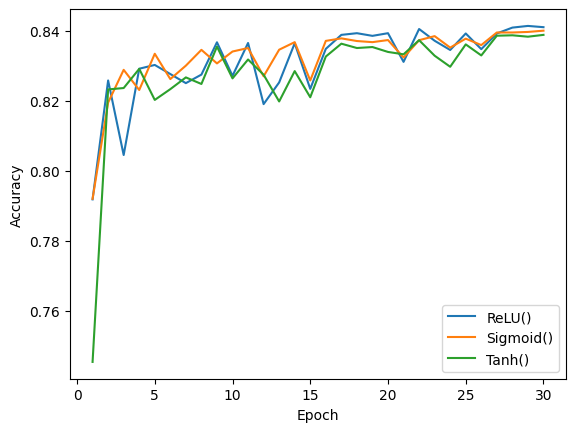

In [ ]:

import matplotlib.pyplot as plt

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
for i, result in enumerate(results):
  plt.plot(np.arange(1, num_epochs + 1), result, label=f"{activation_functions[i]}")
plt.legend()
plt.show()

# Section E

In [ ]:
model_outputs = trainerA.predict(small_eval_dataset)
predicted_classes = np.argmax(model_outputs[0], axis=1) # Derive the predicted class labels by taking the argmax of the model outputs
true_labels = np.array(small_eval_dataset['labels']) # Extract the true labels from the evaluation dataset
misclassified_indices = (predicted_classes != true_labels).nonzero()[0] # Find indices where predictions do not match the true labels

# Randomly select 5 indices of incorrect predictions
# replace=False ensures no repetition in selected indices
selected_misclassified_indices = np.random.choice(misclassified_indices, size=5, replace=False)

# Retrieve the text corresponding to the selected incorrect predictions
misclassified_texts = np.array(small_eval_dataset['text'])[selected_misclassified_indices]

# Iterate through the selected wrong predictions and print detailed information
for i, (idx, text) in enumerate(zip(selected_misclassified_indices, misclassified_texts)):
    print(f"Example {i}:")
    print(f"Prediction: {predicted_classes[idx]}, Label: {true_labels[idx]}")
    print(f"Model Output: {model_outputs[0][idx]}")
    print(text)



Epoch,Training Loss,Validation Loss


Example 0:
Prediction: 1, Label: 0
Model Output: [-0.04401756  0.09477992]
Written by, directed by and starring the champ of camp Bruce Campbell. Easy on its easy to tell this is a budget on a shoestring affair; filmed independently in Bulgaria. All I can really say for sure is that silly is not always funny. Campbell plays an affluent American business man with a cheating wife(Antoinette Byron)and trying to close a business transaction before he is murdered. He hires a cabbie to drive him around a strange little town; not knowing that his wife is 'carrying on' with the taxi driver. Within moments of Campbell being bludgeoned; the cabbie is killed in the same location. A mad scientist(Stacy Keach)proceeds with an experiment putting the cabbie's brain inside the American's head. With massive stitches on his forehead, Campbell breaks free and roams the streets looking for his wife; all the while he is arguing with a strange voice inside his over-sized head. Campbell contorts his rubbery 